<a href="https://colab.research.google.com/github/Lexie-D/Breast-Cancer-Classification/blob/main/Breast_Cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Libraries
import pandas as pd
import numpy as np
import os
import random
import cv2

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

# Viz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

#Image
import PIL.Image
from PIL import Image
from PIL import ImageOps
from IPython.display import display

#Tensor flow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



import requests
import zipfile
import io
import glob

In [25]:
#Uploading the dataset
from google.colab import files
uploaded = files.upload()

Saving Dataset_BUSI_with_GT.zip to Dataset_BUSI_with_GT (1).zip


In [29]:
#unzipping the file
#import zipfile
#import os

zip_path = "Dataset_BUSI_with_GT.zip"
extract_to = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

#confirm location
extracted_path = os.path.join(extract_to, "Dataset_BUSI_with_GT")
print(extracted_path)

/content/Dataset_BUSI_with_GT


In [30]:
os.listdir(extracted_path)

['benign', 'normal', 'malignant']

## Explore the images

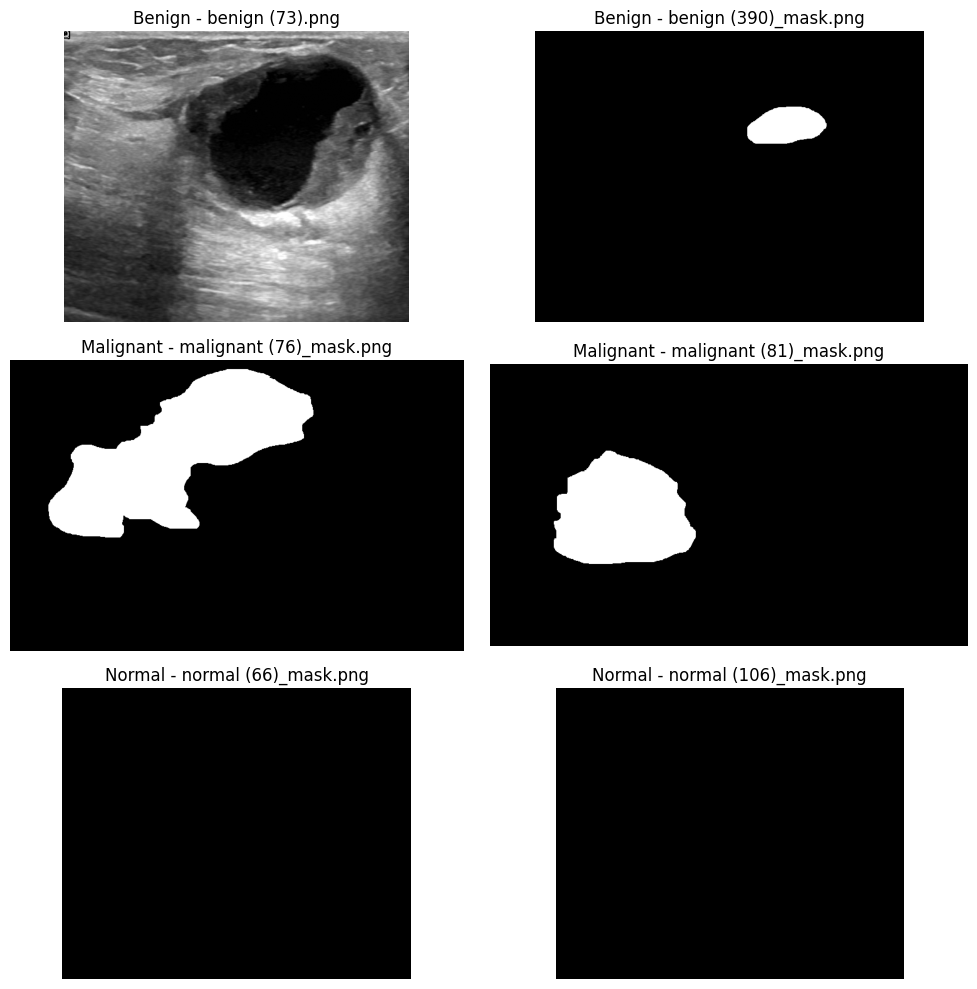

In [36]:
dataset_path = "/content/Dataset_BUSI_with_GT"
categories = ['benign', 'malignant', 'normal']

fig, axs = plt.subplots(len(categories), 2, figsize = (10, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    selected = random.sample(image_files, 2)

    for j in range(2):
        img = os.path.join(category_path, selected[j])
        img = Image.open(img).convert('L')  #images are all grey scale
        axs[i, j].imshow(img, cmap = 'grey')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{category.capitalize()} - {selected[j]}')

plt.tight_layout()
plt.show()

In [37]:
pd.DataFrame(
    os.listdir(extracted_path),
    columns = ['File Name']
)

,File Name
0,benign
1,normal
2,malignant


## All the paths in "extracted_path"

In [38]:
#import glob

In [44]:
train_data = "/content/Dataset_BUSI_with_GT"

In [47]:
# Get all image file paths from subfolders
train_files = glob.glob(os.path.join(train_data, "*", "*.*"))

# Randomly shuffle the lists
random.shuffle(train_files)

# Extract labels from the directory names
labels = [os.path.basename(os.path.dirname(path)) for path in train_files]

# Create list of tuples (file path, label)
data = list(zip(train_files, labels))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Path", "Label"])

df

,Path,Label
0,/content/Dataset_BUSI_with_GT/normal/normal (6...,normal
1,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
2,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
3,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
4,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
...,...,...
1573,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
1574,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
1575,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
1576,/content/Dataset_BUSI_with_GT/normal/normal (1...,normal


## Distribution of Categories (3)

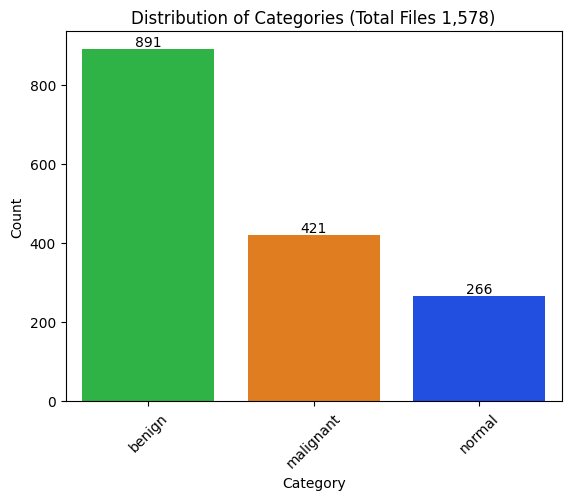

In [63]:
# Descending order
label_order = df['Label'].value_counts().sort_values(ascending = False).index

# Countplot
ax = sns.countplot(x = 'Label', data = df, order = label_order, hue = 'Label', palette = 'bright', legend = False)

# Display the counts per category above bars
for container in ax.containers:
  ax.bar_label(container)

# Plot
ax.set_title('Distribution of Categories (Total Files 1,578)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Collect Data Paths and Labels

In [65]:
# Path to "parent" dataset folder
dataset_path = "/content/Dataset_BUSI_with_GT"

# All image file paths
image_paths = glob.glob(os.path.join(dataset_path, "*", "*.png"))

# Shuffle the paths
np.random.shuffle(image_paths)

# All labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Create DataFrame
df = pd.DataFrame({
    'Path': image_paths,
    'Label': labels
})

df.head()

,Path,Label
0,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
1,/content/Dataset_BUSI_with_GT/benign/benign (7...,benign
2,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
3,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
4,/content/Dataset_BUSI_with_GT/benign/benign (2...,benign


## Split the Dataset
- 70% train
- 15% validation
- 15% test